In [ ]:
import PIL.Image
from PIL import Image, ImageTk
from typing import Tuple
from tkinter import *
import cv2
import numpy as np

In [256]:
from main import *
%reload_ext main

scale = 1
stride = 2
margin = 30

video = cv2.VideoCapture("videos/basketball_3.mp4")

_, first_frame = video.read()
first_frame = preprocess_frame(first_frame, scale=scale)
if False:
    while True:
        selected_box = SelectBoxWindow.show_and_get_box(first_frame)
        if selected_box[-1] != 0 and selected_box[-2] != 0:
            break

# bee (321, 27, 98, 63)
#selected_box = (321, 27, 98, 63) bee
# selected_box = (207, 761, 26, 30)  basketball
# selected_box = (325, 196, 40, 35) bilard
selected_box = np.asarray([319, 22, 141 - 22, 392 - 319])
# selected_box = np.asarray([434, 330, 364 - 330, 465 - 434])
selected_box = np.asarray([328, 611, 355 - 328, 638 - 611]) # basketball_3
print(selected_box)

tracker = ObjectTracker(first_frame, selected_box,
                        stride=stride, margin=margin, 
                        coords_mem_size=1, 
                        sigma=2, 
                        first_last_ratio=[0.5, 0.5], 
                        weights_coef=3.0)
show_tracking_animation(video, tracker, scale=scale, thickness=3, save_path=None, fps=30)

[328 611  27  27]


Elapsed time is 0.000439 seconds.
12.442958513623008


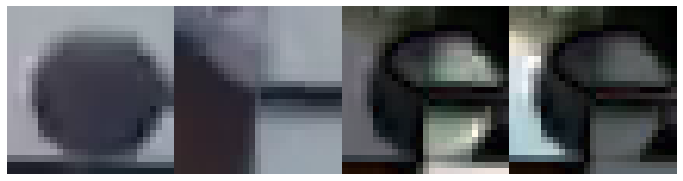

In [251]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import metrics, filters
import cv2
from sklearn.metrics import jaccard_score
from typing import Tuple
import pytictoc

timer = pytictoc.TicToc()

def to_slice(box: Tuple[int,int,int,int]) -> np.s_:
    y,x,w,h = box
    return np.s_[y:y+h, x:x+w]

selected_box = np.asarray([434, 330, 364 - 330, 465 - 434])
selected_box = np.asarray([328, 611, 355 - 328, 638 - 611]) # basketball_3

video = cv2.VideoCapture("videos/basketball_3.mp4")
_, first_frame = video.read()
for _ in range(24):
    _, next_frame = video.read()

def preprocess(im: np.ndarray) -> np.ndarray:
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im / 255
    return (filters.sobel(im) > 0.1).astype('int')


timer.tic()
first_frame = preprocess(first_frame[to_slice(selected_box)])
next_frame = preprocess(next_frame[to_slice(selected_box)])
rs1 = np.abs(np.sqrt(first_frame * next_frame) - next_frame)
rs2 = np.abs(np.sqrt(first_frame * next_frame) - first_frame)
s = np.sum((rs1 - rs2) ** 2)
rs1 = rs1/rs1.max()
rs2 = rs2/rs2.max()
timer.toc()

print(s)

# print(jaccard_score(first_frame, next_frame, average='micro'))

plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(np.hstack([first_frame, next_frame, rs1, rs2]), 'gray')



In [ ]:
import numpy as np
import cv2 as cv2
import argparse
import matplotlib.pyplot as plt


def to_slice(box: tuple, height: int, width: int, margin: int) -> np.s_:
    (x, y, w, h) = box
    x = min(max(0, x - margin), width - w)
    y = min(max(0, y - margin), height - h)
    return np.s_[y : y + h, x : x + w]


margin = 20
selected_box = np.asarray([319, 22, 141 - 22, 392 - 319])
# selected_box = np.asarray([434, 330, 364 - 330, 465 - 434])
cap = cv2.VideoCapture("videos/bee_240.mp4")
# take first frame of the video
ret, fframe = cap.read()
# setup initial location of window
y, x, w, h = selected_box
track_window = (x, y, w, h)
# set up the ROI for tracking


def calculcate_probs_image(
    roi: np.ndarray,
    next_frame: np.ndarray,
    track_window: tuple,
    margin: int,
    stride: int = 1,
) -> np.ndarray:
    height, width = next_frame.shape[:2]
    (x, y, w, h) = track_window

    next_frame = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    sum_images = np.zeros(next_frame.shape)
    sum_indexes = np.zeros(next_frame.shape) + 1e-7
    
    for j in range(
        max(0, y - margin),
        min(height - h, y + margin),
        stride,
    ):
        for i in range(
            max(0, x - margin),
            min(width - w, x + margin),
            stride,
        ):
            index = np.s_[j:j+h, i:i+w]
            obj = next_frame[index]
            err = obj - roi
            sum_images[index] += err / err.max()
            sum_indexes[index] += 1
    data = (sum_images/ sum_indexes)
    return data


def calculate_histogram_mask(frame: np.ndarray, track_window: tuple, bins=50):
    (x, y, w, h) = track_window
    roi = frame[y : y + h, x : x + w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    roi_hist = cv2.calcHist([hsv_roi], [0], None, [bins], [0, 180], accumulate=False)
    return cv2.normalize(roi_hist, 0, 255, cv2.NORM_MINMAX)


roi_hist = calculate_histogram_mask(fframe, track_window, 50)
roi = fframe[y : y + h, x : x + w]

fframe = cv2.cvtColor(fframe, cv2.COLOR_BGR2GRAY)

# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
while 1:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    height, width = frame.shape[:2]
    if ret == True:
        im = np.sqrt((frame * fframe)) - frame
        im = im / im.max()
        # plt.figure(figsize=(16, 8))
        # plt.imshow(im, 'gray')
        # plt.show()
        # break

        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(im, track_window, term_crit)

        # roi_hist = calculate_histogram_mask(frame, track_window)

        # Draw it on image
        x, y, w, h = track_window
        img2 = cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 2)
        roi = frame[y : y + h, x : x + w]
        fframe = frame
        cv2.imshow("img2", img2)
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            break
    else:
        break


cv2.destroyAllWindows()

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pytictoc

timer = pytictoc.TicToc()

margin = 20
term_crit = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1)
selected_box = np.asarray([434, 330, 364 - 330, 465 - 434])
selected_box = np.asarray([319, 22, 141 - 22, 392 - 319])
y, x, w, h = selected_box
track_window = (x, y, w, h)


def to_slice(box: tuple, height: int, width: int, margin: int) -> np.s_:
    (x, y, w, h) = box
    x = min(max(0, x - margin), width - w)
    y = min(max(0, y - margin), height - h)
    return np.s_[y : y + h, x : x + w]

def get_mask(prev: np.ndarray, next: np.ndarray, track_window, margin=20, dsize = (256, 256)) -> np.ndarray:
    index = to_slice(track_window, next.shape[0], next.shape[1], margin)
    prev_box = prev[index]
    next_box = next[index]
    prev = np.zeros_like(prev)
    next = np.zeros_like(next)
    prev[index] = prev_box
    next[index] = next_box
    
    prev_resized = cv.resize(prev, dsize)
    next_resized = cv.resize(next, dsize)
    flow = cv.calcOpticalFlowFarneback(prev_resized, next_resized, None, 0.5, 5, 9, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    
    hsv = np.zeros((*dsize, 3), dtype='uint8')
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 1] = 255
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    bgr = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)
    return cv.resize(bgr, prev.shape[:2][::-1])
    

cap = cv.VideoCapture("videos/basketball_1.mp4")
ret, frame1 = cap.read()
prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
while(1):
    timer.tic()
    ret, frame2 = cap.read()
    he, wi = frame2.shape[:2]
    if not ret:
        print('No frames grabbed!')
        break
    
    next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    
    bgr = get_mask(prvs, next, track_window)
    
    ret, track_window = cv.meanShift(bgr, track_window, term_crit)
    
    # plt.imshow(next[to_slice(track_window, he, wi, margin)], 'gray')
    # plt.show()
    # plt.imshow(flow[..., 1], 'gray')
    # plt.show()

    (x, y, w, h) = track_window
    img2 = cv.rectangle(frame2, (x, y), (x + w, y + h), 255, 2)
    cv.imshow('frame2', bgr)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv.imwrite('opticalfb.png', frame2)
        cv.imwrite('opticalhsv.png', bgr)
    prvs = next

cv.destroyAllWindows()

In [21]:
import math
from matplotlib import pyplot as plt
import numpy as np
from skimage import metrics, filters, morphology
import cv2
from sklearn.metrics import jaccard_score
from typing import Any, Tuple, Deque
import pytictoc
from sklearn import tree
from functools import partial
from skimage import data, segmentation, feature, future
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from collections import deque
from skimage import exposure
from sklearn.svm import SVC, SVR
from sklearn.gaussian_process import GaussianProcessClassifier

timer = pytictoc.TicToc()


def to_slice(box: tuple, height: int, width: int, margin: int) -> np.s_:
    (y, x, w, h) = box
    x = min(max(0, x - margin), width - w - margin)
    y = min(max(0, y - margin), height - h - margin)
    return np.s_[y : y + h + margin * 2, x : x + w + margin * 2]


def to_mask(
    box: tuple, height: int, width: int, margin: int, as_circle=False
) -> np.ndarray:
    (y, x, w, h) = box
    mx = min(x, width - w)
    my = min(y, height - h)
    arr = np.ones((height, width))

    if as_circle:
        arr = cv2.circle(arr, (mx + w // 2, my + h // 2), (w + h) // 4, 2, -1)
    else:
        arr[my : my + h, mx : mx + w] = 2

    x = min(max(0, x - margin), width - w - margin)
    y = min(max(0, y - margin), height - h - margin)
    index = np.s_[y : y + h + margin * 2, x : x + w + margin * 2]
    return arr[index]


def fit_window(seg_im: np.ndarray, window_size: tuple, stride: int = 3) -> tuple:
    seg_im = seg_im == seg_im.max()
    seg_im = morphology.erosion(seg_im)
    
    windows = np.lib.stride_tricks.sliding_window_view(
        seg_im, window_size, axis=(0, 1), writeable=False
    )[::stride, ::stride]

    values = dict()
    for y in range(windows.shape[0]):
        for x in range(windows.shape[1]):
            values[(y * stride, x * stride)] = np.sum(windows[y, x])

    return max(values, key=values.get)

class RandomForest:
    def __init__(
        self,
        fit_per_call=2,
        n_estimators=25,
        n_jobs=12,
        max_depth=5,
        max_samples=0.1,
        sigma_min=0.5,
        sigma_max=15,
        intensity=True,
        edges=True,
        texture=True,
        preprocess_gamma=0.5,
        dataset_size = 5
    ) -> None:
        self.clf = RandomForestClassifier(
            n_estimators=n_estimators,
            n_jobs=n_jobs,
            max_depth=max_depth,
            max_samples=max_samples,
            criterion="entropy",
            class_weight="balanced_subsample",
        )
        self.features_func = partial(
            feature.multiscale_basic_features,
            intensity=intensity,
            edges=edges,
            texture=texture,
            sigma_min=sigma_min,
            sigma_max=sigma_max,
            channel_axis=-1,
        )
        self.trainded = self.clf
        self.gamma = preprocess_gamma
        self.fit_counter = 0
        self.fit_per_call = fit_per_call
        self.training_data: Deque[Tuple[np.ndarray, np.ndarray]] = deque(maxlen=dataset_size)

    def fit(self, sample_weight: Any = None):
        if self.fit_counter % self.fit_per_call == 0:
            _x, _y = [], []
            for (xi,yi) in self.training_data:
              xi = exposure.adjust_gamma(xi, self.gamma)
              xi = self.features_func(xi)
              _x.append(xi), _y.append(yi)
            self.trainded = future.fit_segmenter(np.asarray(_y), np.asarray(_x), self.clf)
        self.fit_counter += 1

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = exposure.adjust_gamma(X, self.gamma)
        features = self.features_func(X)
        return future.predict_segmenter(features, self.clf)

    def append_data(self, X: np.ndarray, y: np.ndarray):
        self.training_data.append((X, y))

# selected_box = np.asarray([528, 687, 754 - 687, 570 - 528])  # car
# selected_box = np.asarray([368, 1169, 1278 - 1169, 429 - 368])  # car_rc_rolling
# selected_box = np.asarray([436, 872, 1224 - 872, 704 - 436])  # car_jumping
# selected_box = np.asarray([428, 368, 386 - 368, 446 - 428]) # bowling_ball
# selected_box = np.asarray([207, 492, 771 - 492, 322 - 207]) # book
# selected_box = np.asarray([199, 514, 562 - 514, 228 - 199]) # bird_2
# selected_box = np.asarray([469, 300, 364 - 300, 554 - 469]) # biker_upper_body
# selected_box = np.asarray([317, 195, 237 - 195, 359 - 317]) # billiard_3
# selected_box = np.asarray([153, 447, 485 - 447, 188 - 153]) # billiard_2
# selected_box = np.asarray([434, 330, 364 - 330, 465 - 434])  # basketball_1
# selected_box = np.asarray([206, 342, 380 - 342 - 8, 245 - 206 - 8]) # basketball_2
selected_box = np.asarray([328, 611, 355 - 328, 638 - 611]) # basketball_3
# selected_box = np.asarray([319, 22, 141 - 22, 392 - 319])  # bee_1


video = cv2.VideoCapture("videos/basketball_3.mp4")
_, first_frame = video.read()
# first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)[..., np.newaxis]
first_frame = first_frame / 255.0

height, width = first_frame.shape[:2]

margin = 90
as_circle = False
clf = RandomForest(
    fit_per_call=3,
    n_estimators=30,
    n_jobs=12,
    max_depth=15,
    max_samples=0.1,
    sigma_min=0.5,
    sigma_max=3.0,
    intensity=True,
    edges=True,
    texture=True,
    preprocess_gamma=0.65,
    dataset_size=6
)

for i in range(800):
    # timer.tic()
    ret, next_frame = video.read()
    if ret == False:
        break
    # next_frame = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)[..., np.newaxis]
    next_frame = next_frame / 255.0

    y, x, w, h = selected_box
    index = to_slice(selected_box, height, width, margin)
    mask = to_mask(selected_box, height, width, margin, as_circle)
    prev_element = np.copy(first_frame[index])
    next_element = np.copy(next_frame[index])

    
    timer.tic()
    clf.append_data(prev_element, mask)
    clf.fit()
    next_element_mask = clf.predict(next_element)
    timer.toc()

    dy, dx = fit_window(next_element_mask, (h, w), stride=4)

    x = min(max(0, x - margin) + dx, width - w - margin)
    y = min(max(0, y - margin) + dy, height - h - margin)

    selected_box = (y, x, w, h)
    first_frame = next_frame
    # timer.toc()

    txt = f"{i}"
    img5 = cv2.rectangle(np.copy(next_frame), (x, y), (x + w, y + h), (0, 1, 0), 2)

    img5 = cv2.rectangle(
        img5, (max(0, x - margin), max(0, y - margin)), (x + w + margin, y + h + margin), (0, 1, 1), 2
    )
    img5 = cv2.putText(img5, txt, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    if i > 0:
        cv2.imshow("img2", img5)
        cv2.imshow("img3", next_element_mask / next_element_mask.max())

    if cv2.waitKey(25) & 0xFF == ord("q"):
        cv2.destroyAllWindows()
        break

cv2.destroyAllWindows()

Elapsed time is 0.145733 seconds.
Elapsed time is 0.031236 seconds.
Elapsed time is 0.030989 seconds.
Elapsed time is 0.505316 seconds.
Elapsed time is 0.030331 seconds.
Elapsed time is 0.030315 seconds.
Elapsed time is 0.753327 seconds.
Elapsed time is 0.028789 seconds.
Elapsed time is 0.030231 seconds.
Elapsed time is 0.778785 seconds.
Elapsed time is 0.031279 seconds.
Elapsed time is 0.029587 seconds.
Elapsed time is 0.702590 seconds.
Elapsed time is 0.029594 seconds.
Elapsed time is 0.035605 seconds.
Elapsed time is 0.733000 seconds.
Elapsed time is 0.031857 seconds.
Elapsed time is 0.031195 seconds.
Elapsed time is 0.760950 seconds.
Elapsed time is 0.029040 seconds.
Elapsed time is 0.030880 seconds.
Elapsed time is 0.779179 seconds.
Elapsed time is 0.031060 seconds.
Elapsed time is 0.029704 seconds.
Elapsed time is 0.713705 seconds.
Elapsed time is 0.029538 seconds.
Elapsed time is 0.030514 seconds.
Elapsed time is 0.717253 seconds.
Elapsed time is 0.028298 seconds.
Elapsed time i

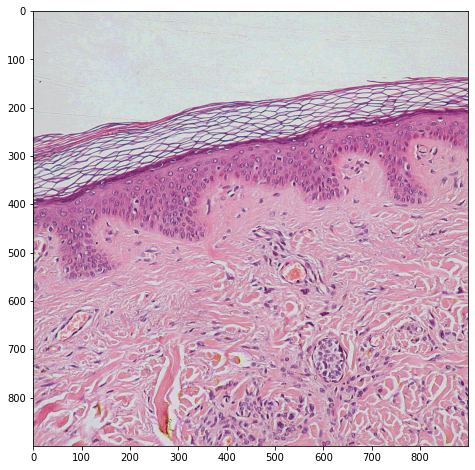

In [446]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from skimage import exposure
full_img = data.skin()

img = full_img[:900, :900] / 255.0

img = np.array(img * 16, dtype='int') / 16 

plt.figure(figsize=(12, 8))
plt.imshow(img)
